The LetoHealth app aids healthcare professionals specializing in infertility aid patients undergoing the IVF process to select the best embryo for lab transfer.

Loading Required Libraries

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


# Grad-CAM

import keras
import matplotlib.cm as cm

In [12]:
from keras.layers import Input, Lambda, Dense, Flatten,Activation, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Reading the data

In [13]:
levels = ['1', '2', '3', '4', '5']
path = "embryo-dataset/ed4/alldata"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'embryo_dataset'])

data['path'] = path + '/' + data['image_file']
data['embryo_dataset'] = data['embryo_dataset'].map({'1': 'Degenerate','2': 'Morula','3':'Early Blastocyst', '4': 'Full Blastocyst','5': 'Hatched Blastocyst'})

samples = 2440

data.head(2400)


,image_file,embryo_dataset,path
0,1/0.png,Degenerate,embryo-dataset/ed4/alldata/1/0.png
1,1/1.png,Degenerate,embryo-dataset/ed4/alldata/1/1.png
2,1/10.png,Degenerate,embryo-dataset/ed4/alldata/1/10.png
3,1/100.png,Degenerate,embryo-dataset/ed4/alldata/1/100.png
4,1/101.png,Degenerate,embryo-dataset/ed4/alldata/1/101.png
...,...,...,...
2395,5/703.png,Hatched Blastocyst,embryo-dataset/ed4/alldata/5/703.png
2396,5/704.png,Hatched Blastocyst,embryo-dataset/ed4/alldata/5/704.png
2397,5/705.png,Hatched Blastocyst,embryo-dataset/ed4/alldata/5/705.png
2398,5/706.png,Hatched Blastocyst,embryo-dataset/ed4/alldata/5/706.png


In [14]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 2440


# Exploratory of Data Analysis

# 1. Count Plot

# 2. Image Samples

In [15]:
IMAGE_SIZE = 75

data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))
data.head()

,image_file,embryo_dataset,path,image
0,1/0.png,Degenerate,embryo-dataset/ed4/alldata/1/0.png,"[[[53, 53, 53], [60, 60, 60], [52, 52, 52], [4..."
1,1/1.png,Degenerate,embryo-dataset/ed4/alldata/1/1.png,"[[[72, 72, 72], [78, 78, 78], [70, 70, 70], [7..."
2,1/10.png,Degenerate,embryo-dataset/ed4/alldata/1/10.png,"[[[56, 56, 56], [43, 43, 43], [34, 34, 34], [5..."
3,1/100.png,Degenerate,embryo-dataset/ed4/alldata/1/100.png,"[[[59, 59, 59], [40, 40, 40], [45, 45, 45], [6..."
4,1/101.png,Degenerate,embryo-dataset/ed4/alldata/1/101.png,"[[[63, 63, 63], [67, 67, 67], [81, 81, 81], [6..."


# Data Modeling

Pre-Process Data

In [16]:
IMAGE_SIZE = 128
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    if data['embryo_dataset'][i] == 'Degenerate':
        label = 1
    elif data['embryo_dataset'][i] == 'Morula':
        label = 2
    elif data['embryo_dataset'][i] == 'Early Blastocyst':
        label = 3
    elif data['embryo_dataset'][i] == 'Full Blastocyst':
        label = 4
    elif data['embryo_dataset'][i] == 'Hatched Blastocyst':
        label = 5
    all_data.append([image, label])

In [17]:
data['embryo_dataset'][0]

'Degenerate'

In [18]:
label

5

Shuffle Data before Train-Test-Split

In [19]:
random.shuffle(all_data)

Train Test Split

In [21]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

val_split = 0.25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = val_split, stratify=y, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1647, 128, 128, 3) (610, 128, 128, 3) (183, 128, 128, 3) (1647,) (610,) (183,)


In [22]:
y

array([4, 2, 5, ..., 5, 4, 3])

In [23]:
y_train[4]

4

# Encode the labels using LabelBinarizer

In [24]:
from sklearn.preprocessing import LabelBinarizer

lb=LabelBinarizer()

y_train=lb.fit_transform(y_train)
y_val=lb.fit_transform(y_val)
y_test=lb.fit_transform(y_test)

In [25]:
y_train[4]

array([0, 0, 0, 1, 0])

In [26]:
y_val[4]

array([1, 0, 0, 0, 0])

In [27]:
y_test[4]

array([0, 0, 0, 0, 1])

In [28]:
#training split
len(x_train)

1647

In [29]:
#testing split
len(x_test)

610

In [30]:
# valuation split
len(x_val)

183

# Resnet50 Model

In [22]:
resnet = ResNet50(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),weights = 'imagenet',include_top = False)

In [23]:
for layer in resnet.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(resnet.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_bl

In [24]:
x = resnet.output
x = Flatten()(x) # Flatten dimensions to use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(5, activation='softmax')(x) # Softmax for multiclass
resnet50_model = Model(inputs=resnet.input, outputs=x)

In [25]:
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [23]:
from tensorflow.keras.optimizers import Nadam

In [24]:
opt = Nadam(learning_rate=1e-4, decay=1e-4)
resnet50_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# Data Augmentation

In [25]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [26]:
# Make sure you provide the same target size as initialied for the image size
BATCH_SIZE = 32
training_set = train_datagen.flow_from_directory('embryo-dataset/ed4/alldata',
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 2440 images belonging to 5 classes.


In [27]:
test_set = test_datagen.flow_from_directory('embryo-dataset/ed4/alldata',
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 2440 images belonging to 5 classes.


In [28]:
history = resnet50_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
77/77 [==============================] - 385s 5s/step - loss: 1.8858 - accuracy: 0.3139 - val_loss: 1.6062 - val_accuracy: 0.1799
Epoch 2/50
77/77 [==============================] - 437s 6s/step - loss: 1.5109 - accuracy: 0.3754 - val_loss: 1.6098 - val_accuracy: 0.1689
Epoch 3/50
77/77 [==============================] - 428s 6s/step - loss: 1.4029 - accuracy: 0.4127 - val_loss: 1.7529 - val_accuracy: 0.2455
Epoch 4/50
77/77 [==============================] - 460s 6s/step - loss: 1.2982 - accuracy: 0.4557 - val_loss: 1.7280 - val_accuracy: 0.1684
Epoch 5/50
77/77 [==============================] - 398s 5s/step - loss: 1.2140 - accuracy: 0.4779 - val_loss: 1.8385 - val_accuracy: 0.1939
Epoch 6/50
77/77 [==============================] - 413s 5s/step - loss: 1.1439 - accuracy: 0.5082 - val_loss: 1.7332 - val_accuracy: 0.1939
Epoch 7/50
77/77 [==============================] - 414s 5s/step - loss: 1.1101 - accuracy: 0.5225 - val_loss: 1.8131 - val_accuracy: 0.1943
Epoch 8/50
77

# Save Model

In [29]:
# h5 is a serialization format
# resnet50_model.save('day5_embryo_resnet50_model.h5')

In [31]:
yp_train = resnet50_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = resnet50_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = resnet50_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

20/20 [==============================] - 13s 670ms/step


# Reports

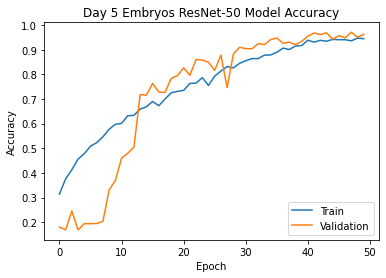

<Figure size 432x288 with 0 Axes>

In [33]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Day 5 Embryos ResNet-50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
plt.savefig('ResNet-50-Embryo-Accuracy-Comparison.png')

In [1]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Day 5 Embryos ResNet-50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
plt.savefig('ResNet-50-Embryo-Loss-Comparison.png')

NameError: name 'plt' is not defined

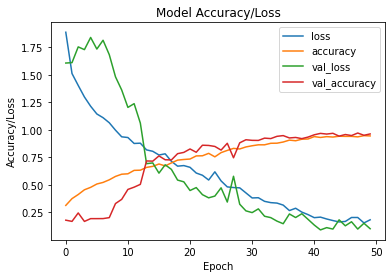

In [67]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

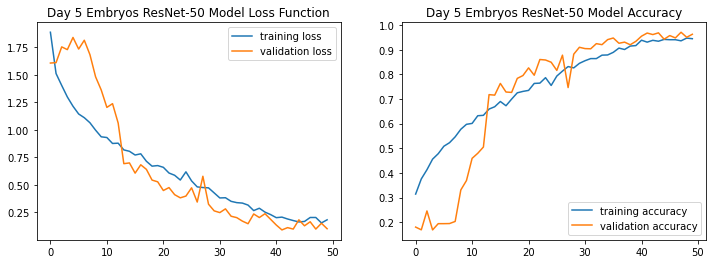

In [77]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Day 5 Embryos ResNet-50 Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Day 5 Embryos ResNet-50 Model Accuracy')
plt.savefig('Results/Day-5 Embryos-ResNet-50 Model-Accuracy-Loss.png')
plt.legend();

# Predicting Test Dataset

20/20 [==============================] - 24s 1s/step


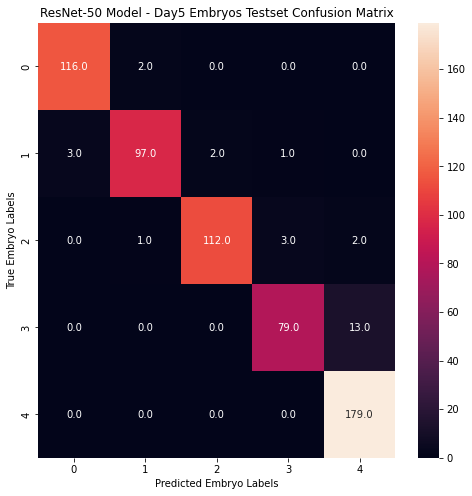

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = resnet50_model.predict(x_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# https://www.v7labs.com/blog/confusion-matrix-guide

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Embryo Labels')
plt.ylabel('True Embryo Labels')
plt.title('ResNet-50 Model - Day5 Embryos Testset Confusion Matrix')
plt.savefig('Results/Day5-Embryos-ResNet-50-Model-Confusion-Matrix.png')
plt.show();

In [42]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       118
           1       0.97      0.94      0.96       103
           2       0.98      0.95      0.97       118
           3       0.95      0.86      0.90        92
           4       0.92      1.00      0.96       179

    accuracy                           0.96       610
   macro avg       0.96      0.95      0.95       610
weighted avg       0.96      0.96      0.96       610



In [44]:
y_train_arg=np.argmax(y_train,axis=1)
yp_train = np.argmax(resnet50_model.predict(x_train),axis=1)
print('Train Confusion Matrix')
print(confusion_matrix(y_train_arg, yp_train))

52/52 [==============================] - 24s 461ms/step
Train Confusion Matrix
[[313   8   3   0   1]
 [  4 265   6   0   0]
 [  0   2 303   6   4]
 [  0   0   2 211  33]
 [  1   0   1   3 481]]


In [45]:
y_val_arg=np.argmax(y_val,axis=1)
yp_val = np.argmax(resnet50_model.predict(x_val),axis=1)
print('Val Confusion Matrix')
print(confusion_matrix(y_val_arg, yp_val))

6/6 [==============================] - 3s 438ms/step
Val Confusion Matrix
[[29  0  0  1  0]
 [ 0 31  2  0  0]
 [ 0  0 39  1  0]
 [ 0  0  0 24  4]
 [ 0  0  0  0 52]]


In [46]:
y_test_arg=np.argmax(y_test,axis=1)
yp_test = np.argmax(resnet50_model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, yp_test))

20/20 [==============================] - 9s 456ms/step
Confusion Matrix
[[116   2   0   0   0]
 [  3  97   2   1   0]
 [  0   1 112   3   2]
 [  0   0   0  79  13]
 [  0   0   0   0 179]]


# Model Evaluation

In [53]:
def evaluation_parametrics(name, y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train_arg, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    #s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train_arg, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train_arg, yp_train, average='micro'),4))
    #print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train_arg, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train_arg, yp_train, average='micro'),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train_arg, yp_train, average='micro'),4))
    # print("ROC AUC Score on Train Data: ", round(roc_auc_score(y_train_arg, yp_train,average='micro'),4))
    print("--------------------------------------------------------------------------")
    
    
    cm_val = confusion_matrix(y_val_arg, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    #s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val_arg, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val_arg, yp_val, average='micro'),4))
    #print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val_arg, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val_arg, yp_val, average='micro'),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val_arg, yp_val, average='micro'),4))
    print("--------------------------------------------------------------------------")


    cm_test = confusion_matrix(y_test_arg, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    #s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test_arg, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test_arg, yp_test, average='micro'), 4))
    #print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test_arg, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test_arg, yp_test, average='micro'), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test_arg, yp_test, average='micro'), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()
    t3.plot()

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


-----------------------------Resnet50 Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       325
           1       0.96      0.96      0.96       275
           2       0.96      0.96      0.96       315
           3       0.96      0.86      0.91       246
           4       0.93      0.99      0.96       486

    accuracy                           0.96      1647
   macro avg       0.96      0.95      0.95      1647
weighted avg       0.96      0.96      0.95      1647

--------------------------------------------------------------------------
Recall on Train Data:  0.9551
Accuracy on Train Data:  0.9551
Precision on Train Data:  0.9551
F1 Score on Train Data:  0.9551
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0 

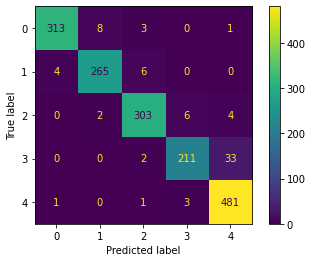

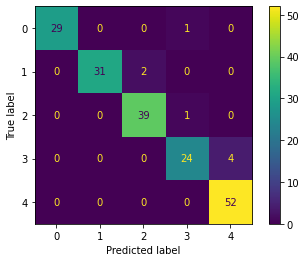

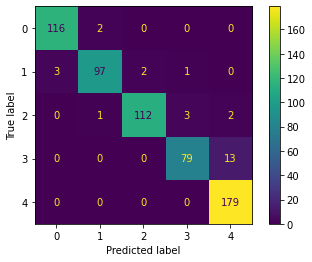

In [55]:
evaluation_parametrics("Resnet50 Neural Network", y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test)

In [58]:
# predict the first 4 images in the test set
prediction = resnet50_model.predict(x_test[:4])
prediction

1/1 [==============================] - 0s 136ms/step


array([[1.3199742e-07, 6.3002432e-07, 1.1801651e-06, 1.5053758e-03,
        9.9849272e-01],
       [5.8214318e-09, 5.5129906e-08, 6.7288340e-07, 8.4001096e-03,
        9.9159920e-01],
       [1.7337935e-38, 4.3566185e-35, 9.6897662e-34, 2.5829709e-15,
        1.0000000e+00],
       [2.4273386e-03, 9.9512345e-01, 2.4369471e-03, 2.5174568e-06,
        9.7661368e-06]], dtype=float32)

In [59]:
y_test[:4]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

# Image Analysis using Grad-CAM

In [74]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.savefig('Results/Resent50-Day5-Embryos-Testset-Images-Heatmap-Analysis.png')
    plt.show()

In [61]:
# Grad-CAM

import keras
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ['embryo-dataset/ed4/alldata/1/20.png',
            'embryo-dataset/ed4/alldata/2/98.png',
            'embryo-dataset/ed4/alldata/3/47.png',
            'embryo-dataset/ed4/alldata/4/50.png',
            'embryo-dataset/ed4/alldata/5/22.png']

In [62]:
# To Get Image into numpy array


def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tf.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [63]:
# Storing Heatmap values into list

resnet50_embryo_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    resnet50_embryo_heatmap.append(heatmap)

1/1 [==============================] - 1s 1s/step


In [64]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], resnet50_embryo_heatmap[i])

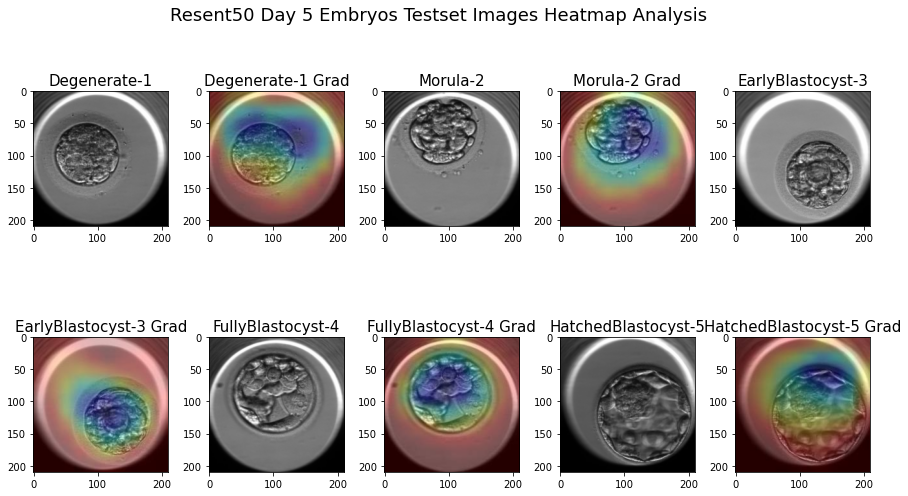

In [75]:
titles_list = ["Degenerate-1",'Degenerate-1 Grad','Morula-2','Morula-2 Grad','EarlyBlastocyst-3','EarlyBlastocyst-3 Grad','FullyBlastocyst-4','FullyBlastocyst-4 Grad', 'HatchedBlastocyst-5','HatchedBlastocyst-5 Grad']

plot_multiple_img(imag, titles_list, ncols = 5, main_title = "Resent50 Day 5 Embryos Testset Images Heatmap Analysis")

# Conclusion

1. Done Exploratory Image Data Analysis on Day 5 Blastocysts vs Non-Blastocysts Images using various techniques.

2. Applied ResNet-50 Convolutional Neural Network Model and got 96% Test Accuracy and 10% Loss

3. Prevented Overfitting by applying Data Augmentation on Train Images Dataset

4. Applied Grad - CAM Analysis on Day 5 Embryos Test Images and found few insights.

# Load Model

# Test the ResNET-50 Model

In [8]:
#load model
from keras.models import load_model
loaded_resnet_model=load_model("day5_embryo_resnet50_model.h5")

In [36]:
classes = [1, 2, 3, 4, 5]
IMG_SIZE = 128

def embryo_predict(imgfilepath):
    
    img_array = cv2.imread(imgfilepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE) )
    # Normalizing the image
    image=new_array/255.0
    prediction = loaded_resnet_model.predict([image.reshape(-1, IMG_SIZE, IMG_SIZE, 3)])
    MaxPosition=np.argmax(prediction)  
    prediction_label=classes[MaxPosition]
    
    if prediction_label == 1:
        return "This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."
    elif prediction_label == 2:
        return "This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."
    elif prediction_label == 3:
        return "This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."
    elif prediction_label == 4:
        return "This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."
    elif prediction_label == 5:
        return "This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [37]:
embryo_predict('embryo-dataset/ed4/alldata/1/0.png')

1/1 [==============================] - 1s 1s/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [38]:
embryo_predict('embryo-dataset/ed4/alldata/2/40.png')

1/1 [==============================] - 0s 64ms/step


"This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."

In [39]:
embryo_predict('embryo-dataset/ed4/alldata/3/126.png')

1/1 [==============================] - 0s 80ms/step


"This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."

In [40]:
embryo_predict('embryo-dataset/ed4/alldata/4/300.png')

1/1 [==============================] - 0s 67ms/step


"This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."

In [41]:
embryo_predict('embryo-dataset/ed4/alldata/5/700.png')

1/1 [==============================] - 0s 81ms/step


"This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [46]:
embryo_predict('test-model/5-400.png')

1/1 [==============================] - 0s 97ms/step


"This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."

In [47]:
embryo_predict('test-model/1-391.png')

1/1 [==============================] - 0s 82ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [48]:
embryo_predict('test-model/2-315.png')

1/1 [==============================] - 0s 80ms/step


"This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [49]:
embryo_predict('test-model/4-14.png')

1/1 [==============================] - 0s 86ms/step


"This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."

# ROC Analysis

In [31]:
# Predicting labels from X_test data
y_pred = loaded_resnet_model.predict(x_test)

20/20 [==============================] - 10s 447ms/step


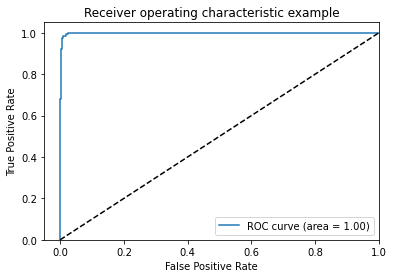

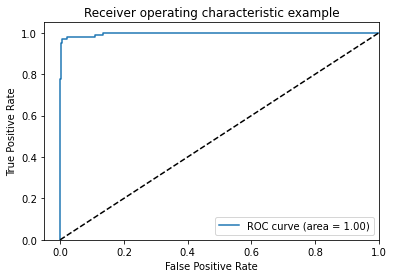

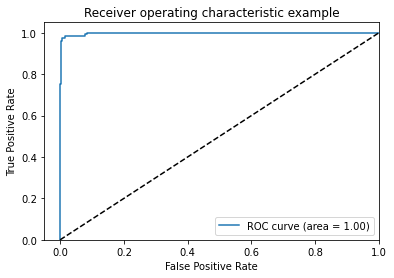

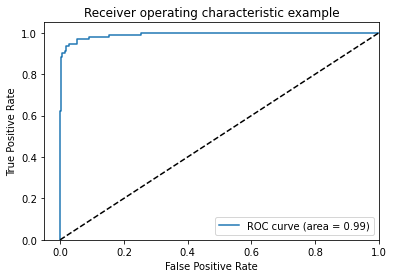

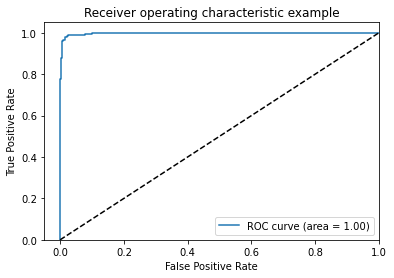

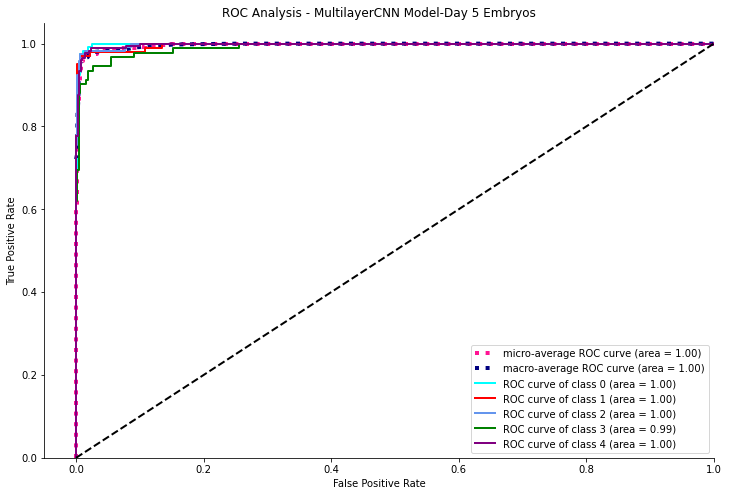

In [32]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#y_test = np.array(y_test)

n_classes = 5


# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'red', 'cornflowerblue', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis - MultilayerCNN Model-Day 5 Embryos')
plt.legend(loc="lower right")
sns.despine()
plt.savefig('Results/ROC-AUC-Resnet-Day5-Embryo-graph.png')
plt.show()